### **1. Construct a multi-layer perceptron to classify the types of glass. Use at least two hidden layer. Perform different trial to find the suitable neurons in each layer. Print the values of the best parameter.**

In [103]:
import pandas as pd

data1 = pd.read_csv('glass.data', header=None, names=['id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'])
data1.head()

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


### Preprocessing

In [104]:
data1 = data1.iloc[:,1:]
data1.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [105]:
from tensorflow import keras
from keras import layers
from kerastuner.tuners import RandomSearch

x = data1.iloc[:,:-1] # independent featuers
y = data1.iloc[:,-1] # dependent features

### For Sparse-categorical-crosseentropy

In [112]:
y = y-1
y

0      0
1      0
2      0
3      0
4      0
      ..
209    6
210    6
211    6
212    6
213    6
Name: Type, Length: 214, dtype: int64

In [113]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(9,)))

    for i in range(hp.Int('layers', 2, 6)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=10,
                                            max_value=30,
                                            step=5),
                               activation='relu'))
        
    model.add(layers.Dense(7, activation='softmax'))
    
    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [114]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='glass_tuner',
    project_name='glass_classification'
    )

In [115]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 5, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 5, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': True}


In [116]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [117]:
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Trial 5 Complete [00h 00m 03s]
val_accuracy: 0.01550387591123581

Best val_accuracy So Far: 0.4573643406232198
Total elapsed time: 00h 00m 17s
INFO:tensorflow:Oracle triggered exit


In [118]:
tuner.results_summary()

Results summary
Results in glass_tuner\glass_classification
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 2
units_0: 10
units_1: 10
learning_rate: 0.01
units_2: 10
units_3: 10
Score: 0.4573643406232198
Trial summary
Hyperparameters:
layers: 4
units_0: 25
units_1: 25
learning_rate: 0.0001
units_2: 10
units_3: 10
Score: 0.24031008034944534
Trial summary
Hyperparameters:
layers: 2
units_0: 30
units_1: 30
learning_rate: 0.0001
units_2: 10
units_3: 10
units_4: 10
Score: 0.13178294897079468
Trial summary
Hyperparameters:
layers: 5
units_0: 25
units_1: 30
learning_rate: 0.0001
units_2: 10
units_3: 30
units_4: 10
Score: 0.10852713137865067
Trial summary
Hyperparameters:
layers: 3
units_0: 15
units_1: 15
learning_rate: 0.0001
units_2: 10
units_3: 10
units_4: 15
Score: 0.01550387591123581


In [119]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9)                 0         
                                                                 
 dense (Dense)               (None, 10)                100       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 7)                 77        
                                                                 
Total params: 287
Trainable params: 287
Non-trainable params: 0
_________________________________________________________________


### **2. Use functional API to build the model as shown below to predict the house price. Use California housing data set. Apply random search for tuning of hyper parameter**

In [121]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the California Housing dataset
california = fetch_california_housing()

# Split the data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(california.data, california.target, test_size=0.2, random_state=42)

# Split the training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=22)

scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_valid_scaled = scalar.transform(X_valid)
X_test_scaled = scalar.transform(X_test)

# Print the shapes of the training and testing sets
print('Training data shape:', X_train.shape, y_train.shape)
print('Testing data shape:', X_test.shape, y_test.shape)

Training data shape: (13209, 8) (13209,)
Testing data shape: (4128, 8) (4128,)


# Creating Model

In [126]:
input_A = keras.layers.Input(shape=[3])
input_B = keras.layers.Input(shape=[5])
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
hidden3 = keras.layers.Dense(30, activation='relu')(input_A)
concat = keras.layers.concatenate([hidden3, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])
model.compile(loss='mse', optimizer='sgd')

# Fitting the Model

In [127]:
X_train_A, X_train_B = X_train_scaled[:, :3], X_train_scaled[:, 3:]
X_valid_A, X_valid_B = X_valid_scaled[:, :3], X_valid_scaled[:, 3:]
X_test_A, X_test_B = X_test_scaled[:, :3], X_test_scaled[:, 3:]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
413/413 [==============================] - 1s 1ms/step - loss: 0.7384 - val_loss: 0.5571
Epoch 2/20
413/413 [==============================] - 0s 997us/step - loss: 0.5109 - val_loss: 0.4943
Epoch 3/20
413/413 [==============================] - 0s 957us/step - loss: 0.4693 - val_loss: 0.4520
Epoch 4/20
413/413 [==============================] - 0s 966us/step - loss: 0.4549 - val_loss: 0.4346
Epoch 5/20
413/413 [==============================] - 0s 1ms/step - loss: 0.4599 - val_loss: 0.4307
Epoch 6/20
413/413 [==============================] - 0s 980us/step - loss: 0.4272 - val_loss: 0.4201
Epoch 7/20
413/413 [==============================] - 0s 980us/step - loss: 0.4118 - val_loss: 0.4058
Epoch 8/20
413/413 [==============================] - 0s 973us/step - loss: 0.4008 - val_loss: 0.4021
Epoch 9/20
413/413 [==============================] - 0s 1ms/step - loss: 0.3944 - val_loss: 0.4007
Epoch 10/20
413/413 [==============================] - 0s 1ms/step - loss: 0.3869 - val_

# Evaluation

In [133]:
# evaluate the model

print(f'Test MSE: {mse_test}')


Test MSE: 0.358232706785202


### **3. Construct C4.5 decision tree to classify cancer data. Apply tree pruning. Display the tree and other performance metrics.**

In [1]:

import pandas as pd
data = pd.read_csv('breast-cancer-wisconsin.data', header=None,names=['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 
        'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 
        'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class'])

data.head()


,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [2]:
# Cleaning data
data = data.replace('?', pd.NA)
data = data.dropna()
print(data[data.values=='?'])

Empty DataFrame
Columns: [Sample code number, Clump Thickness, Uniformity of Cell Size, Uniformity of Cell Shape, Marginal Adhesion, Single Epithelial Cell Size, Bare Nuclei, Bland Chromatin, Normal Nucleoli, Mitoses, Class]
Index: []


In [3]:
# Dropping the first column as it is not required
data=data.iloc[:,1:]

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix
X, y  = data.iloc[:, :-1], data.iloc[:, -1]

y.replace(2, "Malignant", inplace=True)
y.replace(4, "Benign",inplace=True)

y = y.astype('category')
# split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Using DecisionTreeClassifier to implement C4.5 tree

In [5]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy')

### post-pruning the tree to prohibit overfitting

In [6]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print("Alpha values: ",ccp_alphas)
print("Impurities: ",impurities)

Alpha values:  [0.         0.0041841  0.0041841  0.00448056 0.00491321 0.00543646
 0.00576336 0.00608948 0.00661639 0.00747235 0.01023533 0.01454216
 0.01573722 0.02047556 0.02051807 0.03584137 0.14578816 0.59164909]
Impurities:  [0.         0.0041841  0.0083682  0.01284876 0.01776198 0.02863489
 0.04016162 0.0462511  0.05948388 0.06695623 0.07719156 0.09173372
 0.10747094 0.1279465  0.14846457 0.18430594 0.3300941  0.92174319]


### Fitting and making predictions

In [7]:
clf.fit(X_train, y_train)

# make predictions on the testing data
y_pred = clf.predict(X_test)

# evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n",cm)
print("Accuracy:", accuracy)
print("Precision : ", precision_score(y_test, y_pred, average='weighted'))
print("Recall : ", recall_score(y_test, y_pred, average='weighted'))

Confusion matrix:
 [[ 72   6]
 [  2 125]]
Accuracy: 0.9609756097560975
Precision :  0.9613419414573763
Recall :  0.9609756097560975


### Plotting the C4.5 tree

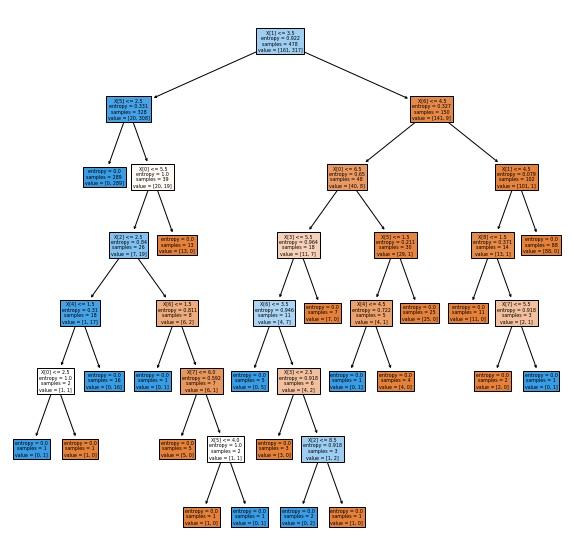

In [8]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# plot the decision tree
plt.figure(figsize=(10, 10))
plot_tree(clf, filled=True)
plt.show()
